In [1]:
import pandas as pd
import random
import torch, torchtext
from torchtext import data
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer as tokenizer
import googletrans
import spacy
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from googletrans import Translator


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravichandra.t\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
SPACY = spacy.load('en_core_web_sm')


In [3]:
## From Here the network portion starts

In [4]:
ip = pd.read_csv("Input_files\\tweets.csv")

In [5]:
import string 
punctuations = list(string.punctuation)
punctuations.append("''")

def preprocess(sentence):
    text_tokens = word_tokenize(sentence)
    tokens_filtered = [i.strip("".join(punctuations)) for i in text_tokens if i not in punctuations]
    tokens_filtered = (" ").join(tokens_filtered)
    #text_tokens = word_tokenize(tokens_filtered)
    #tokens_filtered= [word for word in text_tokens if not word in STOPWORDS]
    return tokens_filtered

In [6]:
for i in ip.index:
    x = preprocess(ip.tweets[i])
    if len(x) == 0:
        ip.at[i, "tweets"] = ip.tweets[i]
    else:
        ip.at[i, "tweets"] = x

In [7]:
ip.head(10)

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,In his teen years Obama has been known to use ...,0
2,IPA Congratulates President Barack Obama for L...,0
3,RT Professor_Why WhatsRomneyHiding his connect...,0
4,RT wardollarshome Obama has approved more targ...,1
5,Video shows federal officials joking about cos...,0
6,one Chicago kid who says Obama is my man tell...,0
7,RT ohgirlphrase American kid You re from the ...,0
8,A valid explanation for why Obama wo n't let w...,1
9,President Obama lt Lindsay Lohan RUMORS beginn...,0


In [8]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
Tweet = torchtext.data.Field(sequential = True, tokenize =tokenizer('spacy'), batch_first =True,include_lengths=True)
Label = torchtext.data.LabelField(tokenize=tokenizer('spacy'),is_target=True, batch_first =True, sequential =True)

In [11]:
fields = [('tweets', Tweet), ('label', Label)]

In [12]:
example = [torchtext.data.Example.fromlist([ip.tweets[i],ip.labels[i]], fields) for i in range(ip.shape[0])] 

In [13]:
TwitterDataset = torchtext.data.Dataset(example, fields)

In [14]:
(train, valid) = TwitterDataset.split(split_ratio=[0.80, 0.20], random_state=random.seed(SEED))
(len(train), len(valid))

(1091, 273)

In [15]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [16]:
import os, pickle
with open('pickles_files\\tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [17]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4403
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1010), ('the', 510), ('RT', 486), (' ', 450), ('http', 389), ('to', 379), ('s', 291), ('of', 234), ('a', 209), ('you', 206)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [18]:
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
enc_hidden_nodes = 100
dec_hidden_nodes = 100
num_output_nodes = 3
batch_size = 32

train_iterator, valid_iterator = torchtext.data.BucketIterator.splits((train,valid), batch_size = batch_size, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)


In [19]:
class Encoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, input_size, hidden_size):
        
        super().__init__() 
        self.hidden_dim = hidden_size
        self.batch_size = batch_size

        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True)       
       
    def forward(self, input,enc_hid,enc_cell):    
        enc_op,(enc_hid,enc_cell) = self.encoder(input,(enc_hid,enc_cell))
        return enc_op,(enc_hid,enc_cell)

    def init_hiddens(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim)
encoder = Encoder(embedding_dim, enc_hidden_nodes)
print(encoder)

Encoder(
  (encoder): LSTM(300, 100, batch_first=True)
)


In [20]:
class Decoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, input_size, hidden_size):
        
        super().__init__() 
        self.hidden_dim = hidden_size        

        self.decoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True)       
       
    def forward(self, input,dec_hid,dec_cell):    
        dec_op,(dec_hid,dec_cell) = self.decoder(input,(dec_hid,dec_cell))
        return dec_op,(dec_hid,dec_cell)

    def init_hiddens(self,batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim)
decoder = Decoder(enc_hidden_nodes,dec_hidden_nodes)
print(decoder)

Decoder(
  (decoder): LSTM(100, 100, batch_first=True)
)


In [21]:
class Classifier(nn.Module):
    def __init__(self, Encoder, Decoder,vocab_size,embedding_dim,enc_hidden_dim,dec_hidden_dim,output_dim,batch_size):
        super().__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.Encoder = Encoder
        self.Decoder = Decoder
        self.enc_hidden_dim = enc_hidden_dim 
        self.batch_size = batch_size       

        self.FCN = nn.Linear(dec_hidden_dim, output_dim)

    def forward(self,tweets):

        enc_hid = self.Encoder.init_hiddens(tweets.shape[0])
        enc_cell = self.Encoder.init_hiddens(tweets.shape[0])        

        embedded = self.embedding(tweets)
        #print(embedded.shape)
        #print(tweets.shape[1])
        for i in range(tweets.shape[1]):
            #print("Tweets:",tweets.shape)
            #print("Encoder_hidden:",enc_hid.shape)            
            enc_op,(enc_hid,enc_cell) = self.Encoder(embedded[:,i:i+1],enc_hid,enc_cell)
            #print("Encoder_output:",enc_op.shape)

        dec_hid = self.Decoder.init_hiddens(tweets.shape[0])
        dec_cell = self.Decoder.init_hiddens(tweets.shape[0])

        dec_ip = enc_hid.reshape(tweets.shape[0],1,self.enc_hidden_dim)

        #print(dec_ip.shape,dec_hid.shape)
        dec_op,(dec_hid,dec_cell) = self.Decoder(dec_ip,dec_hid,dec_cell)

        #print(dec_hid.shape)
        #print(dec_op.shape)
        FCN_op = self.FCN(dec_hid)
        #print(FCN_op.shape)
        # Final activation function softmax
        output = F.softmax(FCN_op[0],dim=1)

        return output

model = Classifier(encoder,decoder,size_of_vocab,embedding_dim,enc_hidden_nodes,dec_hidden_nodes,num_output_nodes,batch_size)
print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

Classifier(
  (embedding): Embedding(4403, 300)
  (Encoder): Encoder(
    (encoder): LSTM(300, 100, batch_first=True)
  )
  (Decoder): Decoder(
    (decoder): LSTM(100, 100, batch_first=True)
  )
  (FCN): Linear(in_features=100, out_features=3, bias=True)
)
The model has 1,562,803 trainable parameters


In [22]:
import torch.optim as optim
#CUDA_LAUNCH_BLOCKING=1
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [23]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()

    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweets, tweets_lengths = batch.tweets  
        
        predictions = model(tweets).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        #print(loss)
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        #print(acc)
        # backpropage the loss and compute the gradients
        loss.backward(retain_graph = True)       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()    
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweets, tweets_length = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweets).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
N_EPOCHS = 200
best_valid_loss = float('inf')
train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
for epoch in range(N_EPOCHS):
     
    # train the model
    print("Epoch:",epoch,flush=True)
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # evaluate the model    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'pickles_files\\saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',flush=True)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n',flush=True)

Epoch: 0
	Train Loss: 1.057 | Train Acc: 65.83%
	 Val. Loss: 0.945 |  Val. Acc: 65.28% 

Epoch: 1
	Train Loss: 0.911 | Train Acc: 68.54%
	 Val. Loss: 0.898 |  Val. Acc: 65.28% 

Epoch: 2
	Train Loss: 0.831 | Train Acc: 71.52%
	 Val. Loss: 0.894 |  Val. Acc: 65.62% 

Epoch: 3
	Train Loss: 0.808 | Train Acc: 76.61%
	 Val. Loss: 0.893 |  Val. Acc: 66.32% 

Epoch: 4
	Train Loss: 0.800 | Train Acc: 78.24%
	 Val. Loss: 0.892 |  Val. Acc: 66.01% 

Epoch: 5
	Train Loss: 0.784 | Train Acc: 78.96%
	 Val. Loss: 0.900 |  Val. Acc: 63.93% 

Epoch: 6
	Train Loss: 0.750 | Train Acc: 81.52%
	 Val. Loss: 0.885 |  Val. Acc: 65.67% 

Epoch: 7
	Train Loss: 0.718 | Train Acc: 84.23%
	 Val. Loss: 0.811 |  Val. Acc: 73.30% 

Epoch: 8
	Train Loss: 0.669 | Train Acc: 89.11%
	 Val. Loss: 0.808 |  Val. Acc: 73.65% 

Epoch: 9
	Train Loss: 0.666 | Train Acc: 89.23%
	 Val. Loss: 0.799 |  Val. Acc: 75.04% 

Epoch: 10
	Train Loss: 0.661 | Train Acc: 89.85%
	 Val. Loss: 0.818 |  Val. Acc: 72.61% 

Epoch: 11
	Train Los

In [26]:
#load weights and tokenizer

path='pickles_files\\saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('pickles_files\\tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en_core_web_sm')

def classify_tweet(tweet):    
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
                        
    
    # Get the model prediction                  
    prediction = model(tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [27]:
class Classifier(nn.Module):
    def __init__(self, Encoder, Decoder,vocab_size,embedding_dim,enc_hidden_dim,dec_hidden_dim,output_dim,batch_size):
        super().__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.Encoder = Encoder
        self.Decoder = Decoder
        self.enc_hidden_dim = enc_hidden_dim 
        self.batch_size = batch_size       

        self.FCN = nn.Linear(dec_hidden_dim, output_dim)

    def forward(self,tweets):

        enc_hid = self.Encoder.init_hiddens(tweets.shape[0])
        enc_cell = self.Encoder.init_hiddens(tweets.shape[0])        

        embedded = self.embedding(tweets)
        #print(embedded.shape)
        #print(tweets.shape[1])
        for i in range(tweets.shape[1]):
            #print("Tweets:",tweets.shape)
            #print("Encoder_hidden:",enc_hid.shape)            
            enc_op,(enc_hid,enc_cell) = self.Encoder(embedded[:,i:i+1],enc_hid,enc_cell)
            #print("Encoder_output:",enc_op.shape)

        dec_hid = self.Decoder.init_hiddens(tweets.shape[0])
        dec_cell = self.Decoder.init_hiddens(tweets.shape[0])

        dec_ip = enc_hid.reshape(tweets.shape[0],1,self.enc_hidden_dim)
        print("Encoder OP:\n",dec_ip)
        #print(dec_ip.shape,dec_hid.shape)
        dec_op,(dec_hid,dec_cell) = self.Decoder(dec_ip,dec_hid,dec_cell)

        #print(dec_hid.shape)
        #print(dec_op.shape)
        print("Decoder OP:\n",dec_hid)
        FCN_op = self.FCN(dec_hid)
        #print(FCN_op.shape)
        # Final activation function softmax
        output = F.softmax(FCN_op[0],dim=1)

        return output

model = Classifier(encoder,decoder,size_of_vocab,embedding_dim,enc_hidden_nodes,dec_hidden_nodes,num_output_nodes,batch_size)

In [28]:
classify_tweet("RT @GottaLaff: RT @markknoller: Pres Obama sayd ""I cannot wait"" for the ""big important debate"" we are going to have on these issues.")

Encoder OP:
 tensor([[[-0.2500,  0.2401,  0.3542,  0.0078,  0.5851, -0.0272,  0.7731,
           0.9793,  0.0924, -0.8139, -0.0468, -0.1147, -0.3047, -0.0651,
          -0.3075, -0.7793,  0.6185,  0.6984,  0.2774,  0.2920,  0.6790,
          -0.3236,  0.4518, -0.0617,  0.3288,  0.0166,  0.1990,  0.5434,
           0.1244,  0.5614, -0.6110,  0.5356,  0.0062, -0.8133, -0.4919,
           0.3591, -0.4690,  0.9638,  0.4381,  0.1008,  0.3220, -0.5002,
          -0.5864,  0.1376,  0.4872,  0.0516, -0.6943,  0.1332, -0.3380,
           0.3728, -0.0825, -0.5353, -0.4323,  0.3923, -0.4564,  0.5510,
           0.6646,  0.9134,  0.5533,  0.0542,  0.5537,  0.8294, -0.9455,
           0.5890, -0.2975, -0.5435, -0.4084, -0.2559, -0.2844, -0.6301,
           0.6059,  0.0312, -0.4909,  0.5651, -0.4194, -0.0985, -0.6021,
           0.2974, -0.6118,  0.5517, -0.0918,  0.6991, -0.2284,  0.1019,
           0.0803,  0.1131, -0.2459, -0.6755, -0.6924, -0.2967, -0.0422,
          -0.0847, -0.9004,  0.1825, -

'Positive'

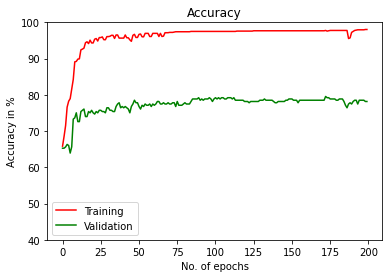

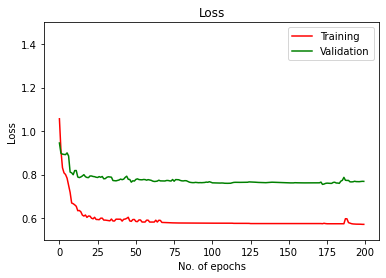

In [34]:
import matplotlib
from matplotlib import pyplot as plt

epoch = range(N_EPOCHS)
plt.plot(epoch, [x*100 for x in train_acc_list],linestyle='solid', color='r', label='Training')
plt.plot(epoch, [x*100 for x in valid_acc_list],linestyle='solid', color='g', label='Validation')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy in %')
plt.ylim(40,100)
plt.title("Accuracy",loc='center')
plt.legend()
plt.show()


epoch = range(N_EPOCHS)
plt.plot(epoch, train_loss_list,linestyle='solid',color='r', label='Training')
plt.plot(epoch, valid_loss_list,linestyle='solid', color='g', label='Validation')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.ylim(0.5,1.5)
plt.title("Loss",loc='center')
plt.legend()
plt.show()
